# Ejercicio 1: Clasificación Binaria con Bank Marketing Dataset

## Introducción:
El Bank Marketing Dataset contiene datos relacionados con campañas de marketing de una institución bancaria. Cada fila representa un cliente contactado, y las columnas incluyen información personal y de contexto, como su ocupación, edad y resultados de campañas anteriores. El objetivo es predecir si el cliente se suscribirá a un depósito a plazo (y = "yes" o y = "no").

## Objetivo del ejercicio:
Aplicar modelos de clasificación binaria, específicamente SVM y KNN, para predecir la respuesta de los clientes a las campañas de marketing. Además, se explorará cómo manejar un conjunto de datos desbalanceado.

## 1. Carga de datos:

Descarga el dataset de UCI Machine Learning RepositoryEnlaces a un sitio externo. o usa una copia local.
Carga el dataset con pandas.

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
  
# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 

In [3]:
# metadata 
type(bank_marketing.metadata)

ucimlrepo.dotdict.dotdict

## 2. Exploración inicial:

Revisa las primeras filas, las dimensiones del dataset, y los valores únicos de la columna objetivo (y).
Realiza un análisis para observar el balance de las clases.

In [4]:
# Combinar datos y objetivo si es necesario
df = pd.concat([X, y], axis=1)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [5]:
df.shape

(45211, 17)

In [6]:
df['y'].unique()

array(['no', 'yes'], dtype=object)

In [7]:
# variable information 
bank_marketing.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,None,no
1,job,Feature,Categorical,Occupation,"type of job (categorical: 'admin.','blue-colla...",None,no
2,marital,Feature,Categorical,Marital Status,"marital status (categorical: 'divorced','marri...",None,no
3,education,Feature,Categorical,Education Level,"(categorical: 'basic.4y','basic.6y','basic.9y'...",None,no
4,default,Feature,Binary,None,has credit in default?,None,no
5,balance,Feature,Integer,None,average yearly balance,euros,no
6,housing,Feature,Binary,None,has housing loan?,None,no
7,loan,Feature,Binary,None,has personal loan?,None,no
8,contact,Feature,Categorical,None,contact communication type (categorical: 'cell...,None,yes
9,day_of_week,Feature,Date,None,last contact day of the week,None,no


In [8]:
result = pd.DataFrame({
    'Null Count': df.isnull().sum(),
    'Type': df.dtypes.apply(lambda dtype: 'Categorical' if dtype == 'object' else 'Non-Categorical'),
})

# Asegurar que las descripciones se agreguen respetando el orden
result['Description'] = list(bank_marketing.variables.description)

result

,Null Count,Type,Description
age,0,Non-Categorical,None
job,288,Categorical,"type of job (categorical: 'admin.','blue-colla..."
marital,0,Categorical,"marital status (categorical: 'divorced','marri..."
education,1857,Categorical,"(categorical: 'basic.4y','basic.6y','basic.9y'..."
default,0,Categorical,has credit in default?
balance,0,Non-Categorical,average yearly balance
housing,0,Categorical,has housing loan?
loan,0,Categorical,has personal loan?
contact,13020,Categorical,contact communication type (categorical: 'cell...
day_of_week,0,Non-Categorical,last contact day of the week


In [9]:
df.dropna(inplace=True)

In [10]:
df.shape

(7842, 17)

In [11]:
# Contar las clases
counts = df['y'].value_counts()
counts

y
no     6056
yes    1786
Name: count, dtype: int64

In [12]:
min_count = counts.min()
min_count

1786

In [13]:
# Muestrear aleatoriamente las filas de cada clase
df_balanced = pd.concat([
    df[df['y'] == 'yes'].sample(min_count, random_state=42),
    df[df['y'] == 'no'].sample(min_count, random_state=42)
])

# Revolver el DataFrame
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

df_balanced

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,31,blue-collar,single,secondary,no,953,yes,no,cellular,14,may,479,1,346,2,success,yes
1,47,technician,married,secondary,no,335,no,no,cellular,4,may,417,1,76,1,success,yes
2,27,technician,single,tertiary,no,-67,yes,no,cellular,6,apr,604,3,236,2,failure,yes
3,40,blue-collar,married,secondary,no,5060,no,no,cellular,10,feb,154,2,93,1,success,yes
4,42,blue-collar,married,secondary,no,1958,yes,no,cellular,18,nov,129,1,172,3,failure,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3567,27,management,single,tertiary,no,20585,no,no,cellular,23,sep,299,1,100,1,success,yes
3568,49,admin.,married,secondary,no,3608,yes,no,cellular,30,apr,252,1,168,1,success,yes
3569,34,technician,single,secondary,no,1279,yes,no,cellular,21,oct,339,3,91,10,success,yes
3570,33,technician,divorced,secondary,no,558,yes,no,cellular,21,nov,258,2,93,3,failure,no


## 3. Preprocesamiento:

- Convierte las columnas categóricas en variables dummy utilizando pd.get_dummies().
- Divide los datos en características (X) y etiquetas (y).
- Normaliza las características numéricas con StandardScaler

In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Convertir columnas categóricas
df_dummies = pd.get_dummies(df_balanced, drop_first=True)

X = df_dummies.drop('y_yes', axis=1)
y = df_dummies['y_yes']

# Normalizar las características numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled

,age,balance,day_of_week,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success
0,-0.840849,-0.220376,-0.047509,0.623010,-0.683051,1.142117,-0.353615,2.266596,-0.155186,-0.13507,...,-0.220766,-0.210819,-0.231034,-0.170582,1.696583,-0.381584,-0.24095,-0.246749,-0.509867,1.533246
1,0.469477,-0.397196,-1.282597,0.390928,-0.683051,-1.153753,-0.653570,-0.441190,-0.155186,-0.13507,...,-0.220766,-0.210819,-0.231034,-0.170582,1.696583,-0.381584,-0.24095,-0.246749,-0.509867,1.533246
2,-1.168431,-0.512215,-1.035579,1.090917,0.698522,0.206763,-0.353615,-0.441190,-0.155186,-0.13507,...,-0.220766,-0.210819,-0.231034,-0.170582,-0.589420,-0.381584,-0.24095,-0.246749,-0.509867,-0.652211
3,-0.103791,0.954704,-0.541544,-0.593548,0.007736,-1.009198,-0.653570,2.266596,-0.155186,-0.13507,...,-0.220766,-0.210819,-0.231034,-0.170582,-0.589420,-0.381584,-0.24095,-0.246749,-0.509867,1.533246
4,0.060000,0.067171,0.446527,-0.687129,-0.683051,-0.337444,-0.053659,2.266596,-0.155186,-0.13507,...,-0.220766,-0.210819,-0.231034,-0.170582,-0.589420,2.620657,-0.24095,-0.246749,-0.509867,-0.652211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3567,-1.168431,5.396663,1.064071,-0.050776,-0.683051,-0.949676,-0.653570,-0.441190,-0.155186,-0.13507,...,-0.220766,-0.210819,-0.231034,-0.170582,-0.589420,-0.381584,-0.24095,4.052702,-0.509867,1.533246
3568,0.633268,0.539263,1.928633,-0.226709,-0.683051,-0.371457,-0.653570,-0.441190,-0.155186,-0.13507,...,-0.220766,-0.210819,-0.231034,-0.170582,-0.589420,-0.381584,-0.24095,-0.246749,-0.509867,1.533246
3569,-0.595163,-0.127102,0.817053,0.098954,0.698522,-1.026205,2.046028,-0.441190,-0.155186,-0.13507,...,-0.220766,-0.210819,-0.231034,-0.170582,-0.589420,-0.381584,4.15024,-0.246749,-0.509867,1.533246
3570,-0.677058,-0.333392,0.817053,-0.204249,0.007736,-1.009198,-0.053659,-0.441190,-0.155186,-0.13507,...,-0.220766,-0.210819,-0.231034,-0.170582,-0.589420,2.620657,-0.24095,-0.246749,-0.509867,-0.652211


## 4. División del dataset:

Divide los datos en conjuntos de entrenamiento (80%) y prueba (20%).

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## 5. Aplicación de SVM:

- Entrena un modelo SVM utilizando sklearn.svm.SVC.
- Evalúa el modelo calculando la matriz de confusión y el reporte de clasificación.

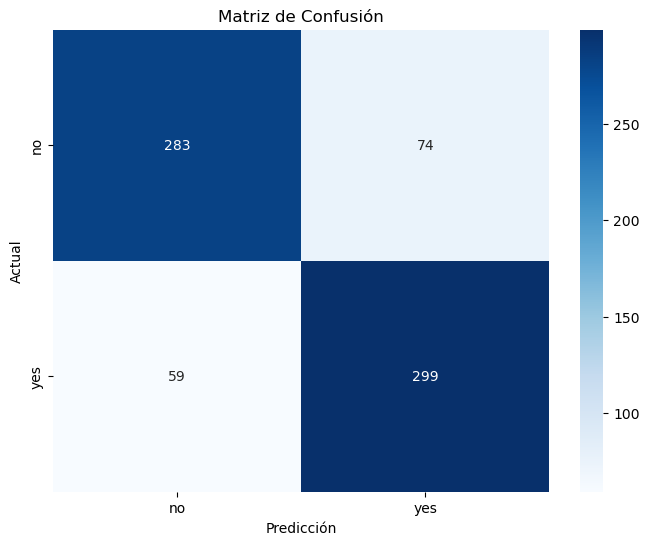

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

clasificador = SVC(kernel='rbf', random_state=42)

clasificador.fit(X_train, y_train)

y_pred = clasificador.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.ylabel('Actual')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

In [17]:
from sklearn.metrics import classification_report
report_dict = classification_report(y_test, y_pred)
report_dict

'              precision    recall  f1-score   support\n\n       False       0.83      0.79      0.81       357\n        True       0.80      0.84      0.82       358\n\n    accuracy                           0.81       715\n   macro avg       0.81      0.81      0.81       715\nweighted avg       0.81      0.81      0.81       715\n'

In [18]:
# Calcular el reporte de clasificación como un diccionario
report_dict = classification_report(y_test, y_pred, target_names=['no', 'yes'], output_dict=True)

# Convertir el diccionario a un DataFrame para una mejor visualización
report_df = pd.DataFrame(report_dict).transpose()

# Mostrar el DataFrame
report_df

,precision,recall,f1-score,support
no,0.827485,0.792717,0.809728,357.000000
yes,0.801609,0.835196,0.818057,358.000000
accuracy,0.813986,0.813986,0.813986,0.813986
macro avg,0.814547,0.813956,0.813893,715.000000
weighted avg,0.814529,0.813986,0.813899,715.000000


## 6. Aplicación de KNN:

- Entrena un modelo KNN utilizando sklearn.neighbors.KNeighborsClassifier.
- Experimenta con diferentes valores de k y observa cómo cambia la precisión.

In [19]:
from sklearn.neighbors import KNeighborsClassifier

In [20]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

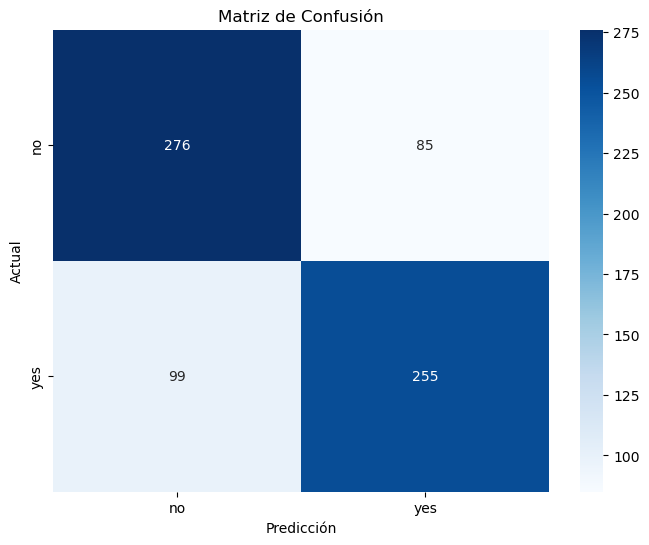

In [22]:
y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.ylabel('Actual')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

In [23]:
# Calcular el reporte de clasificación como un diccionario
report_dict = classification_report(y_test, y_pred, target_names=['no', 'yes'], output_dict=True)

# Convertir el diccionario a un DataFrame para una mejor visualización
report_df = pd.DataFrame(report_dict).transpose()

# Mostrar el DataFrame
report_df

,precision,recall,f1-score,support
no,0.736000,0.764543,0.750000,361.000000
yes,0.750000,0.720339,0.734870,354.000000
accuracy,0.742657,0.742657,0.742657,0.742657
macro avg,0.743000,0.742441,0.742435,715.000000
weighted avg,0.742931,0.742657,0.742509,715.000000


In [24]:
from sklearn.model_selection import cross_val_score
import numpy as np

k_values = [i for i in range (1,31)]
scores = []

scaler = StandardScaler()
X = scaler.fit_transform(X)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))
# Crear un DataFrame para visualizar los resultados
results_df = pd.DataFrame({'k': k_values, 'Score': scores})
results_df

,k,Score
0,1,0.727041
1,2,0.688685
2,3,0.755873
3,4,0.734037
4,5,0.763714
5,6,0.748882
6,7,0.764555
7,8,0.753917
8,9,0.764832
9,10,0.756715


In [25]:
results_df[results_df['Score'] == results_df['Score'].max()]

,k,Score
8,9,0.764832


Text(0, 0.5, 'Accuracy Score')

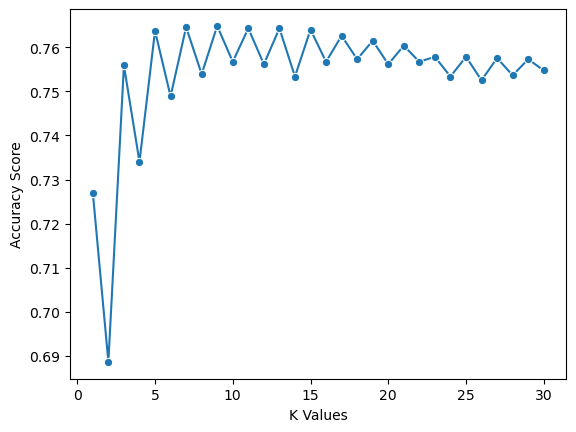

In [26]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [27]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

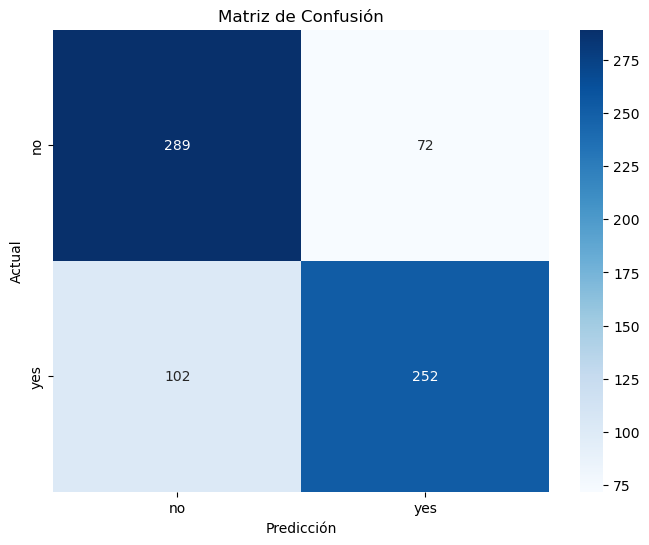

In [28]:
y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.ylabel('Actual')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

In [29]:
# Calcular el reporte de clasificación como un diccionario
report_dict = classification_report(y_test, y_pred, target_names=['no', 'yes'], output_dict=True)

# Convertir el diccionario a un DataFrame para una mejor visualización
report_df = pd.DataFrame(report_dict).transpose()

# Mostrar el DataFrame
report_df

,precision,recall,f1-score,support
no,0.739130,0.800554,0.768617,361.000000
yes,0.777778,0.711864,0.743363,354.000000
accuracy,0.756643,0.756643,0.756643,0.756643
macro avg,0.758454,0.756209,0.755990,715.000000
weighted avg,0.758265,0.756643,0.756114,715.000000


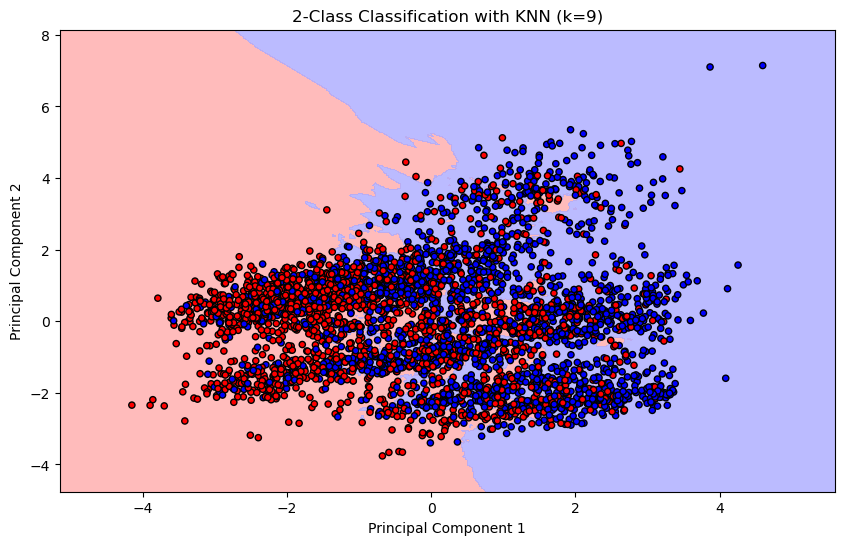

In [30]:
# Reduce dimensionality to 2 for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Train the model with the best k
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_pca, y)

# Create a meshgrid for visualization
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

# Predict classes for each point in the mesh
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Define the color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ['red', 'green', 'blue']

# Plot the decision boundaries
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=ListedColormap(cmap_bold), edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("2-Class Classification with KNN (k=9)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Ejercicio 2: Clasificación Binaria con Heart Disease Dataset

## Introducción:
El Heart Disease Dataset contiene datos médicos de pacientes y sus atributos, como edad, sexo, colesterol y presión arterial. El objetivo es predecir si un paciente tiene o no una enfermedad cardíaca basada en estas características (target = 0 o target = 1).

## Objetivo del ejercicio:
Desarrollar un modelo de clasificación binaria utilizando SVM y KNN para predecir la presencia de enfermedades cardíacas. Además, se introducirán técnicas para la evaluación de métricas de clasificación en problemas de salud.

## Carga de datos:

- Descarga el dataset de Kaggle o una fuente similar.
- Carga los datos en pandas.

In [31]:
df = pd.read_csv('heart.csv')
df.sample(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
547,67,0,0,106,223,0,1,142,0,0.3,2,2,2,1
188,63,1,0,130,254,0,0,147,0,1.4,1,1,3,0
739,52,1,0,128,255,0,1,161,1,0.0,2,1,3,0
617,41,0,1,126,306,0,1,163,0,0.0,2,0,2,1
343,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1


## Exploración inicial:

- Revisa las primeras filas y realiza un análisis descriptivo para entender las características principales.
- Observa el balance de las clases en la columna objetivo (target).

In [32]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [33]:
df.shape

(1025, 14)

In [34]:
df.target.unique()

array([0, 1], dtype=int64)

In [35]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [36]:
# Contar las clases
counts = df['target'].value_counts()
counts

target
1    526
0    499
Name: count, dtype: int64

In [37]:
min_count = counts.min()
min_count

499

In [38]:
# Muestrear aleatoriamente las filas de cada clase
df_balanced = pd.concat([
    df[df['target'] == 0].sample(min_count, random_state=42),
    df[df['target'] == 1].sample(min_count, random_state=42)
])

# Revolver el DataFrame
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

df_balanced

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,54,1,0,124,266,0,0,109,1,2.2,1,1,3,0
1,62,1,2,130,231,0,1,146,0,1.8,1,3,3,1
2,67,1,0,120,229,0,0,129,1,2.6,1,2,3,0
3,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
4,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,54,1,0,120,188,0,1,113,0,1.4,1,1,3,0
994,67,1,2,152,212,0,0,150,0,0.8,1,0,3,0
995,56,1,1,130,221,0,0,163,0,0.0,2,0,3,1
996,56,1,0,132,184,0,0,105,1,2.1,1,1,1,0


In [39]:
# Contar las clases
counts = df_balanced['target'].value_counts()
counts

target
0    499
1    499
Name: count, dtype: int64

## 3. Preprocesamiento:

- Reemplaza los valores nulos o faltantes, si los hay.
- Escala los datos numéricos con StandardScaler.
- Divide los datos en características (X) y etiquetas (y).

In [40]:
df_dummies

,age,balance,day_of_week,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,y_yes
0,31,953,14,479,1,346,2,True,False,False,...,False,False,False,True,False,False,False,False,True,True
1,47,335,4,417,1,76,1,False,False,False,...,False,False,False,True,False,False,False,False,True,True
2,27,-67,6,604,3,236,2,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,40,5060,10,154,2,93,1,True,False,False,...,False,False,False,False,False,False,False,False,True,True
4,42,1958,18,129,1,172,3,True,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3567,27,20585,23,299,1,100,1,False,False,False,...,False,False,False,False,False,False,True,False,True,True
3568,49,3608,30,252,1,168,1,False,False,False,...,False,False,False,False,False,False,False,False,True,True
3569,34,1279,21,339,3,91,10,False,False,False,...,False,False,False,False,False,True,False,False,True,True
3570,33,558,21,258,2,93,3,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [41]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Convertir columnas categóricas
df_dummies = pd.get_dummies(df_balanced, drop_first=True)

X = df_dummies.drop('target', axis=1)  # Eliminar la columna de etiquetas
y = df_dummies['target']  # La columna de etiquetas

# Normalizar las características numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,-0.053745,0.655591,-0.905103,-0.435538,0.381049,-0.418928,-0.99923,-1.730489,1.384965,0.941190,-0.614569,0.227173,1.082733
1,0.834654,0.655591,1.045854,-0.092470,-0.297550,-0.418928,0.89305,-0.125323,-0.722040,0.602853,-0.614569,2.164938,1.082733
2,1.389903,0.655591,-0.905103,-0.664250,-0.336327,-0.418928,-0.99923,-0.862832,1.384965,1.279527,-0.614569,1.196056,1.082733
3,0.612554,0.655591,-0.905103,-0.378360,0.225941,-0.418928,-0.99923,-0.342238,1.384965,1.448695,-0.614569,0.227173,1.082733
4,-1.830542,0.655591,1.045854,0.364954,-1.383308,-0.418928,0.89305,1.046014,-0.722040,-0.919663,1.003743,3.133821,-0.532465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,-0.053745,0.655591,-0.905103,-0.664250,-1.131257,-0.418928,0.89305,-1.556958,-0.722040,0.264516,-0.614569,0.227173,1.082733
994,1.389903,0.655591,1.045854,1.165446,-0.665932,-0.418928,-0.99923,0.048208,-0.722040,-0.242989,-0.614569,-0.741710,1.082733
995,0.168355,0.655591,0.070375,-0.092470,-0.491435,-0.418928,-0.99923,0.612185,-0.722040,-0.919663,1.003743,-0.741710,1.082733
996,0.168355,0.655591,-0.905103,0.021886,-1.208811,-0.418928,-0.99923,-1.904020,1.384965,0.856606,-0.614569,0.227173,-2.147663


## 4. División del dataset:

Divide los datos en conjuntos de entrenamiento y prueba (80/20).

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## 5. Entrenamiento con SVM:

- Entrena un modelo de SVM utilizando un kernel lineal.
- Evalúa el modelo con métricas como precisión, sensibilidad, y F1-score.

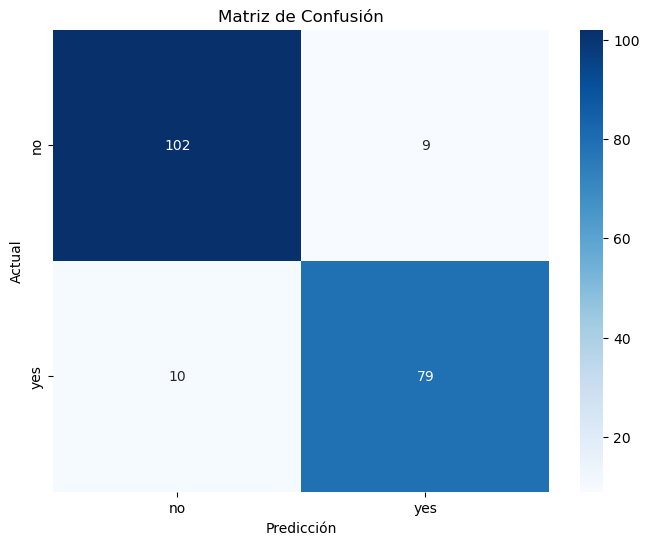

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

clasificador = SVC(kernel='rbf', random_state=42)

clasificador.fit(X_train, y_train)

y_pred = clasificador.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.ylabel('Actual')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

In [44]:
# Calcular el reporte de clasificación como un diccionario
report_dict = classification_report(y_test, y_pred, target_names=['no', 'yes'], output_dict=True)

# Convertir el diccionario a un DataFrame para una mejor visualización
report_df = pd.DataFrame(report_dict).transpose()

# Mostrar el DataFrame
report_df

,precision,recall,f1-score,support
no,0.910714,0.918919,0.914798,111.000
yes,0.897727,0.887640,0.892655,89.000
accuracy,0.905000,0.905000,0.905000,0.905
macro avg,0.904221,0.903280,0.903727,200.000
weighted avg,0.904935,0.905000,0.904945,200.000


## 6. Entrenamiento con KNN:

- Entrena un modelo KNN experimentando con diferentes valores de k.
- Evalúa el modelo con la matriz de confusión y el reporte de clasificación.

In [45]:
from sklearn.neighbors import KNeighborsClassifier

In [46]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [47]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

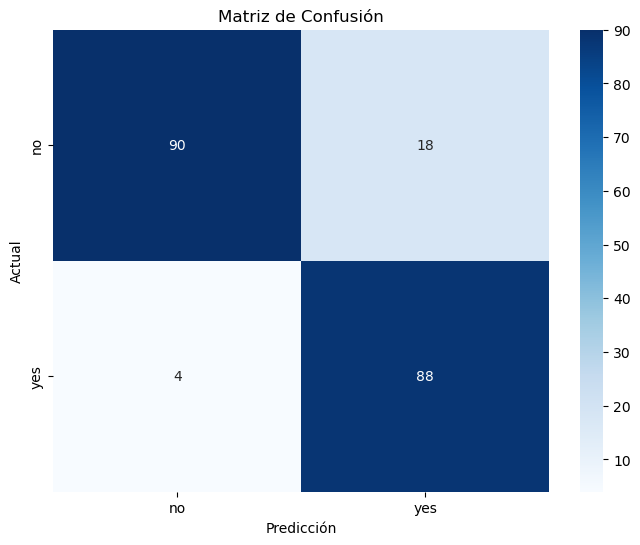

In [48]:
y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.ylabel('Actual')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

In [49]:
# Calcular el reporte de clasificación como un diccionario
report_dict = classification_report(y_test, y_pred, target_names=['no', 'yes'], output_dict=True)

# Convertir el diccionario a un DataFrame para una mejor visualización
report_df = pd.DataFrame(report_dict).transpose()

# Mostrar el DataFrame
report_df

,precision,recall,f1-score,support
no,0.957447,0.833333,0.891089,108.00
yes,0.830189,0.956522,0.888889,92.00
accuracy,0.890000,0.890000,0.890000,0.89
macro avg,0.893818,0.894928,0.889989,200.00
weighted avg,0.898908,0.890000,0.890077,200.00


In [50]:
from sklearn.model_selection import cross_val_score
import numpy as np

k_values = [i for i in range (1,31)]
scores = []

scaler = StandardScaler()
X = scaler.fit_transform(X)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))
# Crear un DataFrame para visualizar los resultados
results_df = pd.DataFrame({'k': k_values, 'Score': scores})
results_df[results_df['Score'] == results_df['Score'].max()]

,k,Score
0,1,0.98698


Text(0, 0.5, 'Accuracy Score')

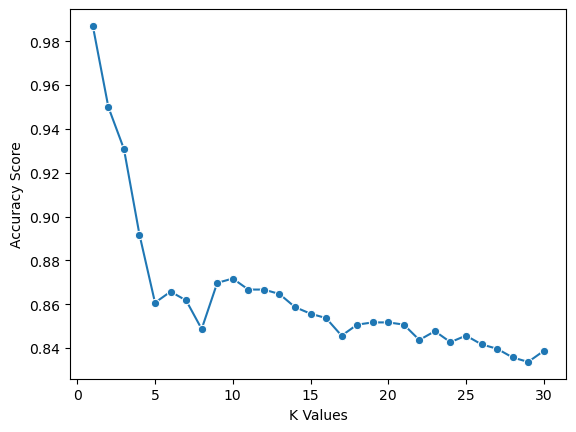

In [51]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [52]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

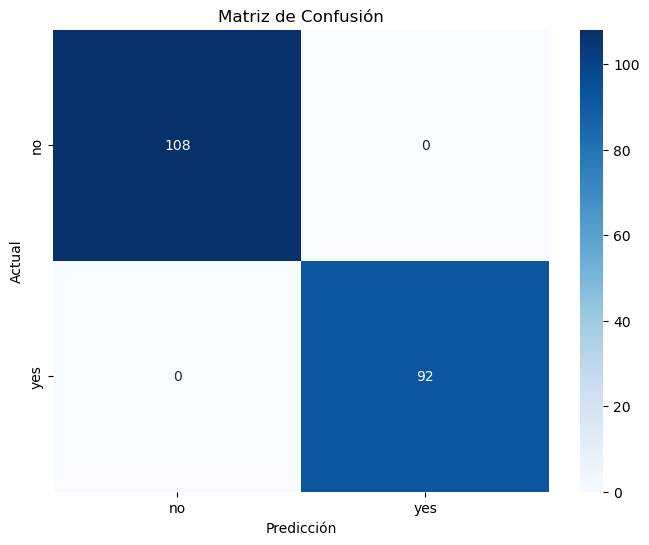

In [53]:
y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.ylabel('Actual')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

In [54]:
# Calcular el reporte de clasificación como un diccionario
report_dict = classification_report(y_test, y_pred, target_names=['no', 'yes'], output_dict=True)

# Convertir el diccionario a un DataFrame para una mejor visualización
report_df = pd.DataFrame(report_dict).transpose()

# Mostrar el DataFrame
report_df

,precision,recall,f1-score,support
no,1.0,1.0,1.0,108.0
yes,1.0,1.0,1.0,92.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,200.0
weighted avg,1.0,1.0,1.0,200.0


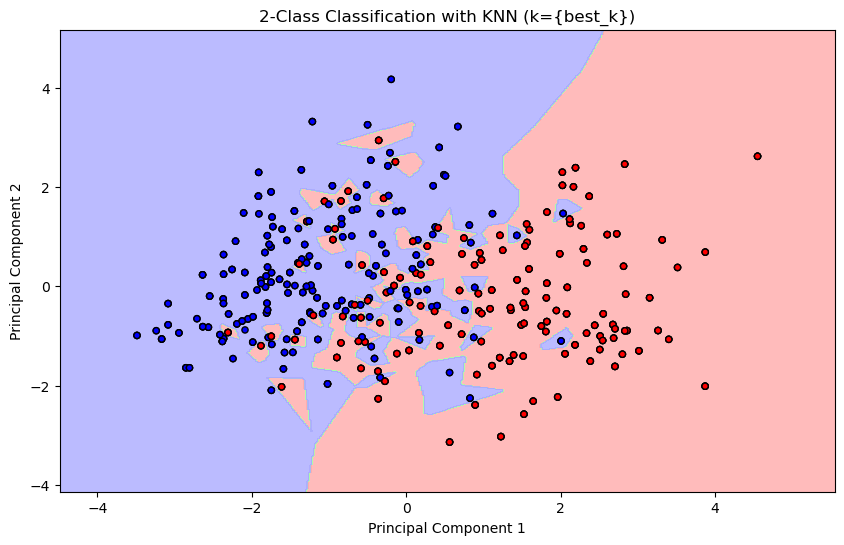

In [55]:
# Reduce dimensionality to 2 for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Train the model with the best k
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_pca, y)

# Create a meshgrid for visualization
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

# Predict classes for each point in the mesh
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Define the color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ['red', 'green', 'blue']

# Plot the decision boundaries
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=ListedColormap(cmap_bold), edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("2-Class Classification with KNN (k={best_k})")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

Parece la mejor pero está muy sobreajustada, intentaremos con 10

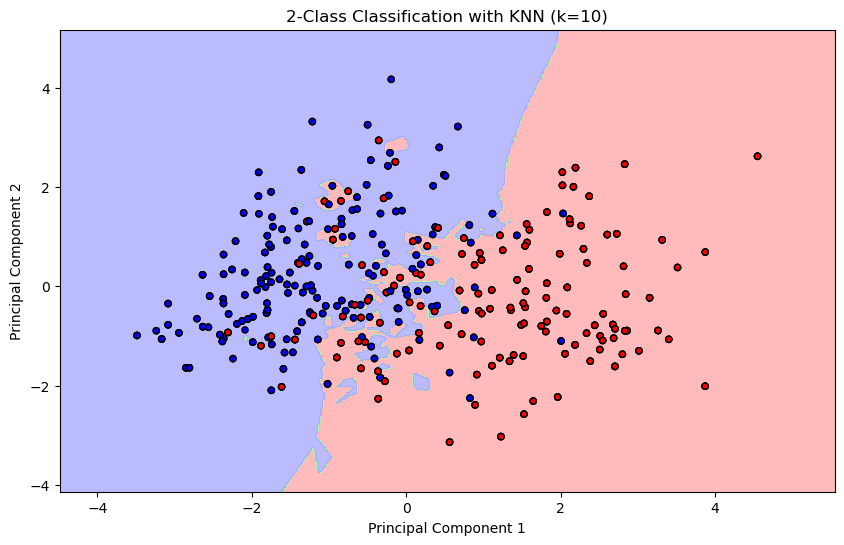

In [56]:
# Reduce dimensionality to 2 for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Train the model with the best k
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_pca, y)

# Create a meshgrid for visualization
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

# Predict classes for each point in the mesh
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Define the color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ['red', 'green', 'blue']

# Plot the decision boundaries
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=ListedColormap(cmap_bold), edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("2-Class Classification with KNN (k=10)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

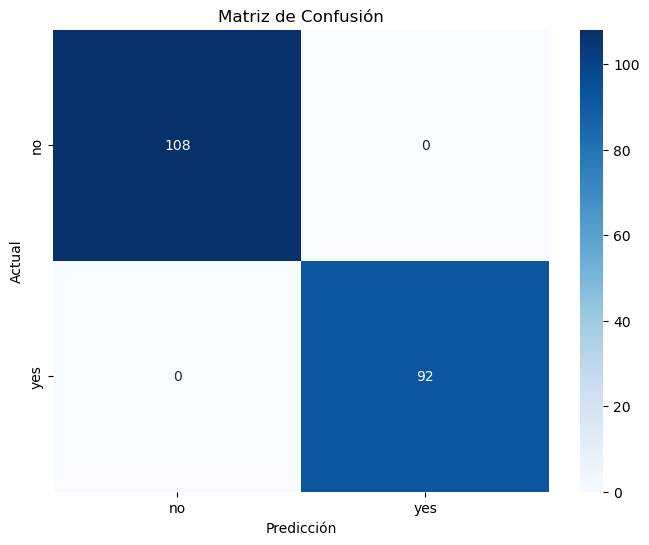

In [57]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.ylabel('Actual')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

Parece adaptarse mejor a los objetivos